<a href="https://colab.research.google.com/github/Rehmatcan/Flavor/blob/main/Flavor_Idea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load your dataset
url = "https://raw.githubusercontent.com/Rehmatcan/Flavor/refs/heads/main/stakeholder_feedback_updated.csv"
df = pd.read_csv(url)

# Preview the dataset
df.head()

,Feedback,Sentiment
0,The solar panels are performing exceptionally ...,Positive
1,"The installation process was smooth, and the p...",Positive
2,Energy efficiency has significantly improved s...,Positive
3,The panels require minimal maintenance and del...,Positive
4,The design fits well with the building aesthet...,Positive


In [ ]:
# 2. Preprocess data
# Encoding the sentiment labels to numeric values (0: Negative, 1: Neutral, 2: Positive, 3: Mixed)
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# 3. Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% training, 20% for validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split the remaining 20% into 10% validation, 10% test

# 4. Convert dataframes to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['Feedback', 'sentiment_encoded']])
val_dataset = Dataset.from_pandas(val_df[['Feedback', 'sentiment_encoded']])
test_dataset = Dataset.from_pandas(test_df[['Feedback', 'sentiment_encoded']])

# Print out the lengths of the datasets for verification
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 621
Validation dataset size: 78
Test dataset size: 78


In [ ]:
# 5. Tokenizer for DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['Feedback'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# 6. Add labels to the dataset
def add_labels(example):
    example['labels'] = example['sentiment_encoded']
    return example

train_dataset = train_dataset.map(add_labels)
val_dataset = val_dataset.map(add_labels)

Map:   0%|          | 0/621 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Map:   0%|          | 0/621 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

In [ ]:
# 7. Prepare model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 8. Define a function to compute metrics
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)  # Convert logits to predicted class labels
    accuracy = accuracy_score(labels, predictions)  # Calculate accuracy
    f1 = f1_score(labels, predictions, average='weighted')  # Calculate F1 score (weighted average for multi-class)
    return {
        'accuracy': accuracy,
        'f1': f1,
    }

In [ ]:
# 9. Define TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluation strategy to adopt during training
    save_strategy="epoch",           # save model every epoch
    load_best_model_at_end=True,     # load the best model when finished training
    metric_for_best_model="accuracy" # Use accuracy to select the best model
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# 10. Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add compute_metrics function
)

<ipython-input-33-296113343581>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 11. Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.391100,1.374215,0.333333,0.282270
2,1.329400,1.249444,0.858974,0.862929
3,0.925900,0.559439,0.987179,0.987094


TrainOutput(global_step=117, training_loss=1.2429054415124094, metrics={'train_runtime': 103.3767, 'train_samples_per_second': 18.021, 'train_steps_per_second': 1.132, 'total_flos': 246795565879296.0, 'train_loss': 1.2429054415124094, 'epoch': 3.0})

In [ ]:
# 12. Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results including accuracy and F1 score
print("Evaluation Results: ", eval_results)

Evaluation Results:  {'eval_loss': 0.5594391822814941, 'eval_accuracy': 0.9871794871794872, 'eval_f1': 0.987093652948796, 'eval_runtime': 1.3895, 'eval_samples_per_second': 56.134, 'eval_steps_per_second': 3.598, 'epoch': 3.0}


In [ ]:
# 13. Get predictions on validation set and visualize learning curve
predictions = trainer.predict(val_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# Convert numeric predictions back to string labels
predicted_labels = label_encoder.inverse_transform(predicted_labels.numpy())

# Add predicted labels to the dataframe
val_df['predicted_sentiment'] = predicted_labels

# Visualize a few predictions
print(val_df[['Feedback', 'Sentiment', 'predicted_sentiment']].head())

                                              Feedback Sentiment  \
329  The materials used are subpar, leading to stru...  Negative   
723  The project team communicated well, but the co...     Mixed   
79   The new HVAC system is extremely energy effici...  Positive   
196  Replacement parts are hard to find and expensive.  Negative   
457  The quality of materials is acceptable, though...   Neutral   

    predicted_sentiment  
329            Negative  
723               Mixed  
79             Positive  
196            Negative  
457             Neutral  


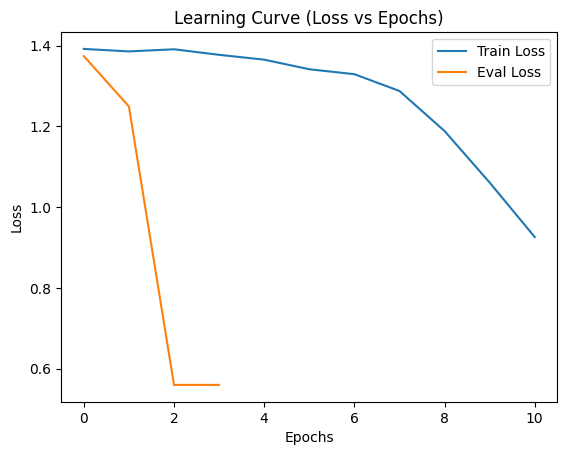

In [ ]:
# 14. Plot Learning Curve (Loss vs Epochs)
history = trainer.state.log_history

# Extracting the loss values during training
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

# Plotting the learning curve
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss vs Epochs)')
plt.legend()
plt.show()